In [16]:
import numpy as np
import pandas as pd

In [17]:
class paths:
    TRAIN = './data/train.csv'
    TEST = './data/test.csv'

In [18]:
train_df = pd.read_csv(paths.TRAIN)

In [19]:
from sklearn.decomposition import PCA

def full_feature_engineering(df, drop_cols=['Y_Maximum', 'Y_Minimum', 'X_Maximum', 'X_Minimum']):
    new_df = df.copy()
    new_df['Height'] = np.abs(new_df['Y_Maximum'] - new_df['Y_Minimum'])
    new_df['Width'] = np.abs(new_df['X_Maximum'] - new_df['X_Minimum'])
    new_df[['Log_Outside_X_Index',
            'Log_X_Perimeter', 'Log_Y_Perimeter']] = np.log(new_df[['Outside_X_Index',
                                                                    'X_Perimeter', 'Y_Perimeter']] + 1e-6)
    new_df[['Log_Width', 'Log_Height']] = np.log(
        new_df[['Width', 'Height']] + 1)
    new_df['Abs_Orientation'] = np.abs(new_df['Orientation_Index'])
    new_df['Log_Range'] = np.log(
        1 + new_df['Maximum_of_Luminosity']) - np.log(1 + new_df['Minimum_of_Luminosity'])
    new_df['Log_Lum'] = np.log(new_df['Sum_of_Luminosity'])
    new_df['Log_Avg_Lum'] = new_df['Log_Lum'] - 2 * new_df['LogOfAreas']

    y_cols = ['Pastry', 'Z_Scratch', 'K_Scatch',
              'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
    non_cols = ['id'] + y_cols

    X = new_df.drop(columns=non_cols)
    X_stats = X.describe().T
    X = (X - X_stats['mean']) / X_stats['std']
    pca = PCA().fit(X)
    new_df[[f'pca_{i}' for i in range(
        len(pca.components_))]] = pca.transform(X)

    new_df['No Defect'] = (new_df[y_cols].sum(axis=1) == 0).astype('int')

    return new_df.drop(columns=drop_cols)

## Logit Ensemble Weight Selection

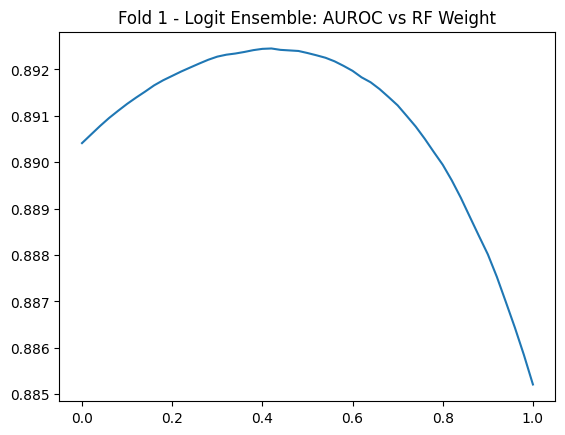

Fold 1: Weight Max 0.42, AUROC 0.8924


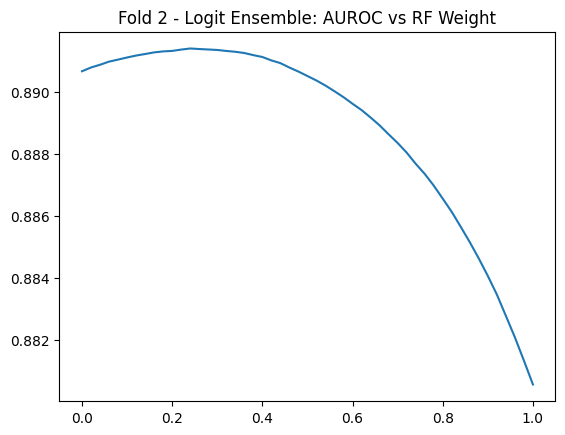

Fold 2: Weight Max 0.24, AUROC 0.8914


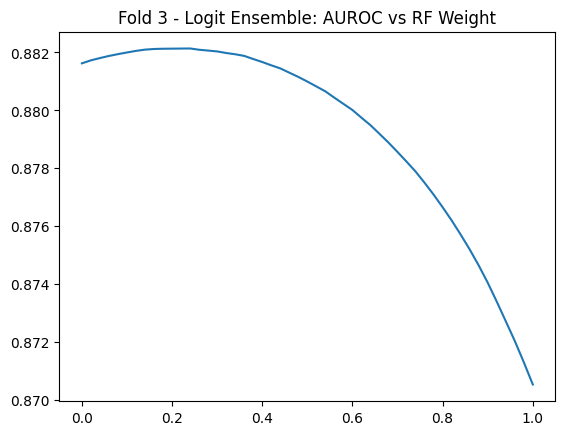

Fold 3: Weight Max 0.24, AUROC 0.8821


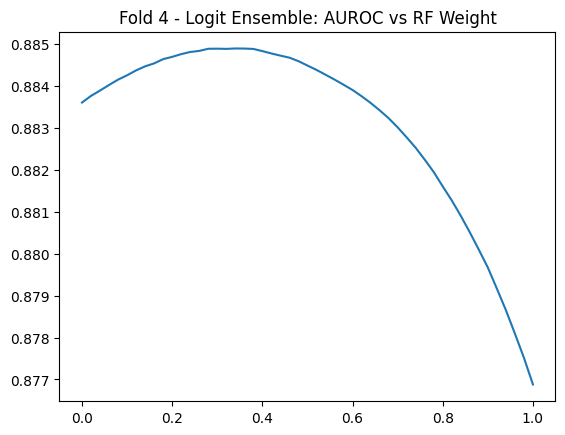

Fold 4: Weight Max 0.34, AUROC 0.8849


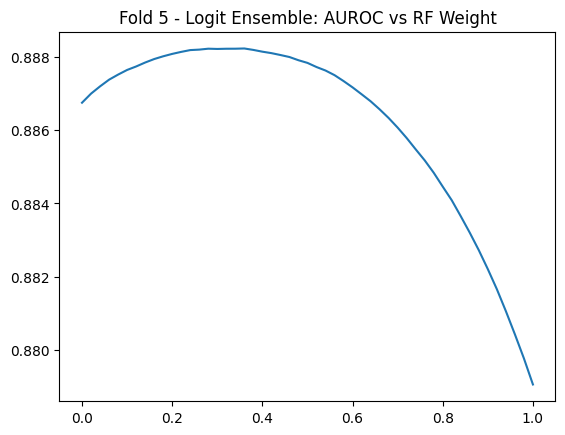

Fold 5: Weight Max 0.36, AUROC 0.8882


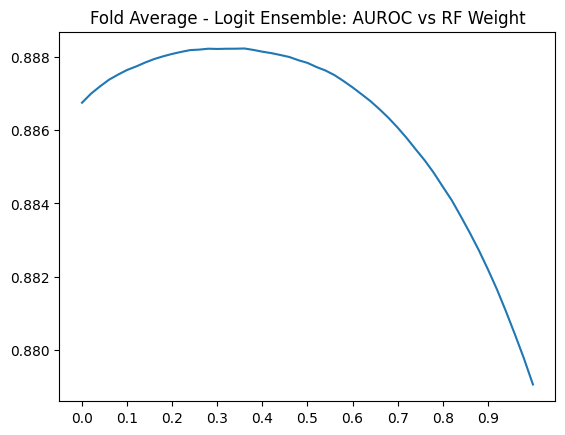

Average AUROC: 0.8878


In [26]:
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

gkf = GroupKFold(n_splits=5)
aucs = np.zeros(8)

rf_cols = ['Y_Maximum', 'Y_Minimum', 'X_Maximum', 'X_Minimum',
           'pca_37']
rf_df = full_feature_engineering(train_df, drop_cols=rf_cols)

xgb_cols = ['Y_Maximum', 'Y_Minimum', 'X_Maximum', 'X_Minimum',
            'Log_Outside_X_Index', 'Log_X_Perimeter', 'Log_Y_Perimeter',
            'Log_Width', 'Log_Lum', 'Log_Height', 'Height', 'pca_3',
            'pca_28', 'pca_25', 'pca_30', 'pca_33', 'pca_36', 'pca_31',
            'pca_37', 'pca_35', 'pca_26', 'pca_23', 'pca_20', 'pca_19',
            'pca_17', 'pca_16', 'pca_9', 'pca_2', 'pca_1', 'LogOfAreas',
            'Edges_X_Index', 'pca_13', 'pca_29', 'pca_22', 'pca_14', 'pca_32',
            'pca_34', 'pca_18', 'pca_27', 'pca_15', 'pca_11', 'Outside_Global_Index',
            'pca_21', 'pca_10', 'pca_8', 'pca_7', 'Log_X_Index', 'pca_24', 'Log_Y_Index']
xgb_df = full_feature_engineering(train_df, drop_cols=xgb_cols)


y_cols = ['No Defect', 'Pastry', 'Z_Scratch', 'K_Scatch',
          'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
real_cols = ['Pastry', 'Z_Scratch', 'K_Scatch',
             'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
y = rf_df[y_cols]
ids = train_df['id']

X_rf = rf_df.drop(columns=[*y_cols, 'id'])
X_xgb = xgb_df.drop(columns=[*y_cols, 'id'])


rf_params = {
    'n_estimators': 5000,
    'max_samples': 0.15,
    'max_features': 33,
    'n_jobs': -1,
    'random_state': 0,
    'class_weight': 'balanced',
}

xgb_params = {
    'n_estimators': 1500,
    'n_jobs': -1,
    'early_stopping_rounds': 9,
    'lambda': 1e-7,
    'learning_rate': 0.0123,
    'alpha': 3.059, 
    'subsample': 0.712
}

auroc_maxes = np.zeros(5)
weight_maxes = np.zeros(5)
total_aurocs = np.zeros(51)
for fold, (train_index, valid_index) in enumerate(gkf.split(X_rf, y, ids)):
    train_X_rf = X_rf.loc[train_index]
    valid_X_rf = X_rf.loc[valid_index]

    train_X_xgb = X_xgb.loc[train_index]
    valid_X_xgb = X_xgb.loc[valid_index]

    train_y = y.loc[train_index]
    valid_y = y.loc[valid_index]

    # RF
    rf_model = RandomForestClassifier(**rf_params)
    rf_model.fit(train_X_rf, train_y)

    rf_preds = np.array(rf_model.predict_proba(valid_X_rf))[:, :, 1].T

    # XGB
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(train_X_xgb, train_y, eval_set=[(valid_X_xgb, valid_y)], verbose=0)

    xgb_preds = np.array(xgb_model.predict_proba(valid_X_xgb))

    # Logits
    rf_logits = np.log((0.00001 + rf_preds)/(1.00001 - rf_preds))
    xgb_logits = np.log((0.00001 + xgb_preds)/(1.00001 - xgb_preds))

    ensemble_aurocs = np.zeros(51)
    for idx in range(51):
        weight = idx / 50.
        ensemble_logits = weight * rf_logits + (1 - weight) * xgb_logits
        exp_logits = np.exp(ensemble_logits)
        ensemble_preds = exp_logits / (1 + exp_logits)
        ensemble_aurocs[idx] = np.array(roc_auc_score(valid_y, ensemble_preds,
                                        multi_class='ovr', average=None))[1:].mean()
        
    plt.plot(np.arange(0.0, 1.01, 0.02), ensemble_aurocs)
    plt.title(f'Fold {fold+1} - Logit Ensemble: AUROC vs RF Weight')
    plt.show()
    total_aurocs += ensemble_aurocs
    auroc_maxes[fold] = np.max(ensemble_aurocs)
    weight_maxes[fold] = np.argmax(ensemble_aurocs) / 50.
    print(f'Fold {fold+1}: Weight Max {weight_maxes[fold]:.2f}, AUROC {auroc_maxes[fold]:.4f}')

total_aurocs /= 5
plt.plot(np.arange(0.0, 1.01, 0.02), ensemble_aurocs)
plt.title(f'Fold Average - Logit Ensemble: AUROC vs RF Weight')
plt.xticks(np.arange(0.0, 1.0, step=0.1))
plt.show()

print(f'Average AUROC: {np.mean(auroc_maxes):.4f}')